# LETID - Outdoor Environments 

### Example: LETID progression in outdoor environments
Author: Joe Karas | joseph.karas@nrel.gov

2023
***

We can use the equations in this library to model LETID progression in a simulated outdoor environment, given that we have weather and system data. This example makes use of tools from the fabulous [pvlib](https://pvlib-python.readthedocs.io/en/stable/) library to calculate system irradiance and temperature, which we use to calculate progression in LETID states.

This will illustrate the potential of "Temporary Recovery", i.e., the backwards transition of the LETID defect B->A that can take place with carrier injection at lower temperatures.


**Requirements:**
- `pvlib`, `pandas`, `numpy`, `matplotlib`

**Objectives:**
1. Use `pvlib` and provided weather files to set up a temperature and injection timeseries
2. Define necessary solar cell device parameters
3. Define necessary degradation parameters: degraded lifetime and defect states
4. Run through timeseries, calculating defect states
5. Calculate device degradation and plot


In [116]:
# if running on google colab, uncomment the next line and execute this cell to install the dependencies and prevent "ModuleNotFoundError" in later cells:
# !pip install pvdeg==0.1.1

In [117]:
from pvdeg import letid, collection, utilities, weather, DATA_DIR

import pvlib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

### First, we'll use pvlib to create and run a model system, and use the irradiance, temperature, and operating point of that model to set up our LETID model
For this example, we'll model a fixed latitude tilt system using PVGIS hourly PSM weather data, and module and inverter models from the CEC database.

In [118]:
weather, months_selected, inputs, metadata = pvlib.iotools.get_pvgis_tmy(latitude=45.57, longitude=5.94, map_variables=True)

In [119]:
import datetime as dt 

coerce_year = 2020
data = weather

data.index = data.index.map(lambda dt: dt.replace(year=coerce_year))

weather.index = data.index


In [120]:
#if our weather file doesn't have precipitable water, calculate it with pvlib
if not 'precipitable_water' in weather.columns:
    weather['precipitable_water'] = pvlib.atmosphere.gueymard94_pw(weather['temp_air'], weather['relative_humidity'])


In [121]:
# rename some columns for pvlib if they haven't been already
weather.rename(columns = {'GHI':'ghi', 'DNI':'dni', 'DHI':'dhi', 'Temperature':'temp_air', 'Wind Speed':'wind_speed', 'Relative Humidity':'relative_humidity', 'Precipitable Water':'precipitable_water'}, inplace = True)
weather = weather[['ghi', 'dni', 'dhi', 'temp_air', 'wind_speed', 'relative_humidity', 'precipitable_water']]

In [122]:
#note, i'm could only get pvdeg 0.1.2 (?), so I don't have this function in weather.py 
def repeat_annual_time_series(time_series, start_year, n_years):
    """
    Repeat a pandas time series dataframe containing annual data.
    For example, repeat TMY data by n_years, adding in leap days as necessary.
    For now, this function requires 1 or more full years of uniform
    interval (non-leap year) data, i.e. length must be a multiple of 8760.
    On leap days, all data is set to 0.

    TODO: make it possible to have weirder time series, e.g. non uniform intervals.
    Include option for synthetic leap day data

    Parameters:
    -----------
    time_series : (pd.DataFrame)
        pandas dataframe with DatetimeIndex

    time_series : (int)
        desired starting year of time_series

    n_years : (int)
        number of years to repeat time_series

    Returns:
    --------
    new_time_series : (pd.DataFrame)
        pandas dataframe repeated n_years
    """

    if len(time_series) % 8760 != 0:
        raise ValueError("Length of time_series must be a multiple of 8760")

    tz = time_series.index.tz
    time_series = time_series.tz_localize(
        None
    )  # timezone aware timeseries can cause problems, we'll make it tz-naive for now

    time_series.index = time_series.index.map(lambda dt: dt.replace(year=start_year))

    start = time_series.index[0]

    for year in range(start_year, start_year + n_years):
        if year == start_year:
            if is_leap_year(year):
                this_year = time_series.copy()
                this_year.index = time_series.index.map(
                    lambda dt: dt.replace(year=year)
                )
                this_year = pd.concat(
                    [
                        this_year[: str(year) + "-02-28"],
                        pd.DataFrame(
                            0,
                            index=pd.date_range(
                                start=datetime.datetime(
                                    year=year, month=2, day=29, minute=start.minute
                                ),
                                end=datetime.datetime(year=year, month=3, day=1),
                                freq="H",
                            ),
                            columns=time_series.columns,
                        ),
                        this_year[str(year) + "-03-01" :],
                    ]
                )
                new_time_series = this_year

            else:
                this_year = time_series.copy()
                this_year.index = time_series.index.map(
                    lambda dt: dt.replace(year=year)
                )
                new_time_series = this_year

        else:
            if is_leap_year(year):
                this_year = time_series.copy()
                this_year.index = time_series.index.map(
                    lambda dt: dt.replace(year=year)
                )
                this_year = pd.concat(
                    [
                        this_year[: str(year) + "-02-28"],
                        pd.DataFrame(
                            0,
                            index=pd.date_range(
                                start=datetime.datetime(
                                    year=year, month=2, day=29, minute=start.minute
                                ),
                                end=datetime.datetime(year=year, month=3, day=1),
                                freq="H",
                            ),
                            columns=time_series.columns,
                        ),
                        this_year[str(year) + "-03-01" :],
                    ]
                )
                new_time_series = pd.concat([new_time_series, this_year])

            else:
                this_year = time_series.copy()
                this_year.index = time_series.index.map(
                    lambda dt: dt.replace(year=year)
                )
                new_time_series = pd.concat([new_time_series, this_year])

    new_time_series.index = new_time_series.index.tz_localize(
        tz=tz
    )  # add back in the timezone

    return new_time_series


def is_leap_year(year):
    """Returns True if year is a leap year"""
    if year % 4 != 0:
        return False
    elif year % 100 != 0:
        return True
    elif year % 400 != 0:
        return False
    else:
        return True

In [123]:
#repeat weather data 5 years

weather = repeat_annual_time_series(weather, 2020, 5)

C:\Users\pjka009\AppData\Local\Temp\ipykernel_26104\882515187.py:54: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index=pd.date_range(
C:\Users\pjka009\AppData\Local\Temp\ipykernel_26104\882515187.py:86: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index=pd.date_range(


In [124]:
# import pvlib stuff and pick a module and inverter. Choice of these things will slightly affect the pvlib results which we later use to calculate injection.
# we'll use the SAPM temperature model open-rack glass/polymer coeffecients. 

from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.location import Location
from pvlib.pvsystem import PVSystem
from pvlib.modelchain import ModelChain

cec_modules = pvlib.pvsystem.retrieve_sam('CECMod')
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

cec_module = cec_modules['Jinko_Solar_Co___Ltd_JKM260P_60']
cec_inverter = cec_inverters['ABB__ULTRA_750_TL_OUTD_1_US_690_x_y_z__690V_']

temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']


In [125]:
# set up system in pvlib
latitude = inputs['location']['latitude']
longitude = inputs['location']['longitude']
elevation = inputs['location']['elevation']
tz = weather.index.tz
surface_tilt = latitude # fixed, latitude tilt
surface_azimuth = 180 # south-facing

location = Location(latitude, longitude, tz, elevation, 'Chambery, France')

system = PVSystem(surface_tilt = surface_tilt, surface_azimuth = surface_azimuth,
                  module_parameters = cec_module,
                  inverter_parameters = cec_inverter,
                  temperature_model_parameters = temperature_model_parameters,
                  )

In [126]:
# create and run pvlib modelchain
mc = ModelChain(system, location, aoi_model = "physical")
mc.run_model(weather)

c:\Users\pjka009\AppData\Local\anaconda3\envs\pvdeg\Lib\site-packages\pvlib\spectrum\mismatch.py:358: UserWarning: Exceptionally low pw values replaced with 0.1 cm to prevent model divergence
  warn('Exceptionally low pw values replaced with '


ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: sandia_inverter
  aoi_model: physical_aoi_loss
  spectral_model: first_solar_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

## Set up timeseries
In this example, injection is a function of both the operating point of the module (which we will assume is maximum power point) and irradiance. Maximum power point injection is equivalent to $(I_{sc}-I_{mp})/I_{sc}\times Ee$, where $Ee$ is effective irradiance, the irradiance absorbed by the module's cells. We normalize it to 1-sun irradiance, 1000 $W/m^2$.

We will use the irradiance, DC operating point, and cell temperature from the pvlib modelchain results.

In [127]:
ee = mc.results.effective_irradiance
#injection = (mc.results.dc['i_sc']-mc.results.dc['i_mp'])/(mc.results.dc['i_sc'])*(ee/1000)
cell_injection = letid.calc_injection_outdoors(mc.results)
cell_temperature = mc.results.cell_temperature

timesteps = pd.DataFrame({'Temperature':cell_temperature, 'Injection':cell_injection}) # create a DataFrame with cell temperature and injection
timesteps.reset_index(inplace = True) # reset the index so datetime is a column. I prefer integer indexing.
timesteps.rename(columns = {'index':'Datetime'}, inplace = True)


In [128]:
# filter out times when injection is NaN, these won't progress LETID, and it'll make the calculations below run faster
timesteps = timesteps[timesteps['Injection'].notnull()]
timesteps.reset_index(inplace = True, drop = True)

In [129]:
timesteps

,Datetime,Temperature,Injection
0,2020-01-01 08:00:00+00:00,8.645709,0.000636
1,2020-01-01 09:00:00+00:00,10.573536,0.003673
2,2020-01-01 10:00:00+00:00,11.388111,0.004225
3,2020-01-01 11:00:00+00:00,12.471372,0.005354
4,2020-01-01 12:00:00+00:00,12.456558,0.005014
...,...,...,...
21641,2024-12-31 11:00:00+00:00,11.881418,0.004092
21642,2024-12-31 12:00:00+00:00,11.677459,0.003751
21643,2024-12-31 13:00:00+00:00,11.485945,0.003480
21644,2024-12-31 14:00:00+00:00,13.831392,0.009352


## Device and degradation parameters
To define a device, we need to define several important quantities about the device: wafer thickness (in $\mu m$), rear surface recombination velocity (in cm/s), and cell area (in cm<sup>2</sup>).

In [131]:
parameters_perc = {'wafer_thickness': 180,
                   's_rear': 90,
                   'cell_area': 243,
                   'd_base': 27,
                   'tau_0' : 371,
                   'tau_deg' : 90,
                   }

parameters_bsf = {'wafer_thickness': 180,
                   's_rear': 500,
                   'cell_area': 243,
                   'd_base': 27,
                   'tau_0' : 200,
                   'tau_deg' : 49,
                   }

##### Other device parameters
Other required device parameters: and optical generation profile, which allow us to estimate current collection in the device.


In [130]:
generation_df = pd.read_excel(os.path.join(DATA_DIR, 'PVL_GenProfile.xlsx'), header = 0) # this is an optical generation profile generated by PVLighthouse's OPAL2 default model for 1-sun, normal incident AM1.5 sunlight on a 180-um thick SiNx-coated, pyramid-textured wafer.
generation = generation_df['Generation (cm-3s-1)']
depth = generation_df['Depth (um)']

##### Remaining degradation parameters:
The rest of the quantities to define are: the initial percentage of defects in each state (A, B, and C), and the dictionary of mechanism parameters.

In this example, we'll assume the device starts in the fully-undegraded state (100% state A), and we'll use the kinetic parameters for LETID degradation from Repins.

In [132]:
# starting defect state percentages
nA_0 = 100
nB_0 = 0
nC_0 = 0

mechanism_params = utilities.get_kinetics('repins')

timesteps[['NA', 'NB', 'NC', 'tau']] = np.nan # create columns for defect state percentages and lifetime, fill with NaNs for now, to fill iteratively below

tau_0 = parameters_perc['tau_0']
tau_deg = parameters_perc['tau_deg']
wafer_thickness = parameters_perc['wafer_thickness']
s_rear = parameters_perc['s_rear']
d_base = parameters_perc['d_base']

timesteps.loc[0, ['NA', 'NB', 'NC']] = nA_0, nB_0, nC_0 # assign first timestep defect state percentages
timesteps.loc[0, 'tau'] = letid.tau_now(tau_0, tau_deg, nB_0) # calculate tau for the first timestep

## Run through timesteps
Since each timestep depends on the preceding timestep, we need to calculate in a loop. This will take a few minutes depending on the length of the timeseries.

In [133]:
for index, timestep in timesteps.iterrows():
    
    # first row tau has already been assigned
    if index == 0:
        #calc device parameters for first row
        tau = tau_0
        jsc = collection.calculate_jsc_from_tau_cp(tau, wafer_thickness, d_base, s_rear, generation, depth)
        voc = letid.calc_voc_from_tau(tau, wafer_thickness, s_rear, jsc, temperature = 25)
        timesteps.at[index, 'Jsc'] = jsc
        timesteps.at[index, 'Voc'] = voc
    
    # loop through rows, new tau calculated based on previous NB. Reaction proceeds based on new tau.
    else:
        n_A = timesteps.at[index-1, 'NA']
        n_B = timesteps.at[index-1, 'NB']
        n_C = timesteps.at[index-1, 'NC']

        tau = letid.tau_now(tau_0, tau_deg, n_B)
        jsc = collection.calculate_jsc_from_tau_cp(tau, wafer_thickness, d_base, s_rear, generation, depth)
        
        temperature = timesteps.at[index, 'Temperature']
        injection = timesteps.at[index, 'Injection']

        # calculate defect reaction kinetics: reaction constant and carrier concentration factor.
        k_AB = letid.k_ij(mechanism_params['v_ab'], mechanism_params['ea_ab'], temperature)
        k_BA = letid.k_ij(mechanism_params['v_ba'], mechanism_params['ea_ba'], temperature)
        k_BC = letid.k_ij(mechanism_params['v_bc'], mechanism_params['ea_bc'], temperature)
        k_CB = letid.k_ij(mechanism_params['v_cb'], mechanism_params['ea_cb'], temperature)

        x_ab = letid.carrier_factor(tau, 'ab', temperature, injection, jsc, wafer_thickness, s_rear, mechanism_params)
        x_ba = letid.carrier_factor(tau, 'ba', temperature, injection, jsc, wafer_thickness, s_rear, mechanism_params)
        x_bc = letid.carrier_factor(tau, 'bc', temperature, injection, jsc, wafer_thickness, s_rear, mechanism_params)

        # calculate the instantaneous change in NA, NB, and NC
        dN_Adt = (k_BA * n_B * x_ba) - (k_AB * n_A * x_ab)
        dN_Bdt = (k_AB * n_A * x_ab) + (k_CB * n_C) - ((k_BA * x_ba + k_BC * x_bc) * n_B)
        dN_Cdt = (k_BC * n_B * x_bc) - (k_CB * n_C)

        t_step = (timesteps.at[index, 'Datetime'] - timesteps.at[index-1,'Datetime']).total_seconds()
        
        # assign new defect state percentages
        timesteps.at[index, 'NA'] = n_A + dN_Adt*t_step
        timesteps.at[index, 'NB'] = n_B + dN_Bdt*t_step
        timesteps.at[index, 'NC'] = n_C + dN_Cdt*t_step

        #calculate device parameters
        timesteps.at[index, 'tau'] = tau
        timesteps.at[index, 'Jsc'] = jsc
        timesteps.at[index, 'Voc'] = letid.calc_voc_from_tau(tau, wafer_thickness, s_rear, jsc, temperature = 25)

In [134]:
timesteps['tau'] = letid.tau_now(tau_0, tau_deg, timesteps['NB'])

# calculate device Jsc for every timestep. Unfortunately this requires an integration so I think we have to run through a loop. Device Jsc allows calculation of device Voc.
for index, timestep in timesteps.iterrows():
    jsc_now = collection.calculate_jsc_from_tau_cp(timesteps.at[index, 'tau'], wafer_thickness, d_base, s_rear, generation, depth)
    timesteps.at[index, 'Jsc'] = jsc_now
    timesteps.at[index, 'Voc'] = letid.calc_voc_from_tau(timesteps.at[index, 'tau'], wafer_thickness, s_rear, jsc_now, temperature = 25)


In [135]:
timesteps = letid.calc_device_params(timesteps, cell_area = 243) # this function quickly calculates the rest of the device parameters: Isc, FF, max power, and normalized max power

timesteps_perc = timesteps


## Do it again, this time for a BSF cell

In [142]:
ee = mc.results.effective_irradiance
#injection = (mc.results.dc['i_sc']-mc.results.dc['i_mp'])/(mc.results.dc['i_sc'])*(ee/1000)
cell_injection = letid.calc_injection_outdoors(mc.results)
cell_temperature = mc.results.cell_temperature

timesteps = pd.DataFrame({'Temperature':cell_temperature, 'Injection':cell_injection}) # create a DataFrame with cell temperature and injection
timesteps.reset_index(inplace = True) # reset the index so datetime is a column. I prefer integer indexing.
timesteps.rename(columns = {'index':'Datetime'}, inplace = True)


In [143]:
# filter out times when injection is NaN, these won't progress LETID, and it'll make the calculations below run faster
timesteps = timesteps[timesteps['Injection'].notnull()]
timesteps.reset_index(inplace = True, drop = True)

In [144]:
# starting defect state percentages
nA_0 = 100
nB_0 = 0
nC_0 = 0

mechanism_params = utilities.get_kinetics('repins')

timesteps[['NA', 'NB', 'NC', 'tau']] = np.nan # create columns for defect state percentages and lifetime, fill with NaNs for now, to fill iteratively below

tau_0 = parameters_bsf['tau_0']
tau_deg = parameters_bsf['tau_deg']
wafer_thickness = parameters_bsf['wafer_thickness']
s_rear = parameters_bsf['s_rear']
d_base = parameters_bsf['d_base']

timesteps.loc[0, ['NA', 'NB', 'NC']] = nA_0, nB_0, nC_0 # assign first timestep defect state percentages
timesteps.loc[0, 'tau'] = letid.tau_now(tau_0, tau_deg, nB_0) # calculate tau for the first timestep

In [145]:
for index, timestep in timesteps.iterrows():
    
    # first row tau has already been assigned
    if index == 0:
        #calc device parameters for first row
        tau = tau_0
        jsc = collection.calculate_jsc_from_tau_cp(tau, wafer_thickness, d_base, s_rear, generation, depth)
        voc = letid.calc_voc_from_tau(tau, wafer_thickness, s_rear, jsc, temperature = 25)
        timesteps.at[index, 'Jsc'] = jsc
        timesteps.at[index, 'Voc'] = voc
    
    # loop through rows, new tau calculated based on previous NB. Reaction proceeds based on new tau.
    else:
        n_A = timesteps.at[index-1, 'NA']
        n_B = timesteps.at[index-1, 'NB']
        n_C = timesteps.at[index-1, 'NC']

        tau = letid.tau_now(tau_0, tau_deg, n_B)
        jsc = collection.calculate_jsc_from_tau_cp(tau, wafer_thickness, d_base, s_rear, generation, depth)
        
        temperature = timesteps.at[index, 'Temperature']
        injection = timesteps.at[index, 'Injection']

        # calculate defect reaction kinetics: reaction constant and carrier concentration factor.
        k_AB = letid.k_ij(mechanism_params['v_ab'], mechanism_params['ea_ab'], temperature)
        k_BA = letid.k_ij(mechanism_params['v_ba'], mechanism_params['ea_ba'], temperature)
        k_BC = letid.k_ij(mechanism_params['v_bc'], mechanism_params['ea_bc'], temperature)
        k_CB = letid.k_ij(mechanism_params['v_cb'], mechanism_params['ea_cb'], temperature)

        x_ab = letid.carrier_factor(tau, 'ab', temperature, injection, jsc, wafer_thickness, s_rear, mechanism_params)
        x_ba = letid.carrier_factor(tau, 'ba', temperature, injection, jsc, wafer_thickness, s_rear, mechanism_params)
        x_bc = letid.carrier_factor(tau, 'bc', temperature, injection, jsc, wafer_thickness, s_rear, mechanism_params)

        # calculate the instantaneous change in NA, NB, and NC
        dN_Adt = (k_BA * n_B * x_ba) - (k_AB * n_A * x_ab)
        dN_Bdt = (k_AB * n_A * x_ab) + (k_CB * n_C) - ((k_BA * x_ba + k_BC * x_bc) * n_B)
        dN_Cdt = (k_BC * n_B * x_bc) - (k_CB * n_C)

        t_step = (timesteps.at[index, 'Datetime'] - timesteps.at[index-1,'Datetime']).total_seconds()
        
        # assign new defect state percentages
        timesteps.at[index, 'NA'] = n_A + dN_Adt*t_step
        timesteps.at[index, 'NB'] = n_B + dN_Bdt*t_step
        timesteps.at[index, 'NC'] = n_C + dN_Cdt*t_step

        #calculate device parameters
        timesteps.at[index, 'tau'] = tau
        timesteps.at[index, 'Jsc'] = jsc
        timesteps.at[index, 'Voc'] = letid.calc_voc_from_tau(tau, wafer_thickness, s_rear, jsc, temperature = 25)

In [146]:
timesteps['tau'] = letid.tau_now(tau_0, tau_deg, timesteps['NB'])

# calculate device Jsc for every timestep. Unfortunately this requires an integration so I think we have to run through a loop. Device Jsc allows calculation of device Voc.
for index, timestep in timesteps.iterrows():
    jsc_now = collection.calculate_jsc_from_tau_cp(timesteps.at[index, 'tau'], wafer_thickness, d_base, s_rear, generation, depth)
    timesteps.at[index, 'Jsc'] = jsc_now
    timesteps.at[index, 'Voc'] = letid.calc_voc_from_tau(timesteps.at[index, 'tau'], wafer_thickness, s_rear, jsc_now, temperature = 25)


In [147]:
timesteps = letid.calc_device_params(timesteps, cell_area = 243) # this function quickly calculates the rest of the device parameters: Isc, FF, max power, and normalized max power


In [148]:
timesteps_bsf = timesteps

In [149]:
timesteps_perc

,Datetime,Temperature,Injection,NA,NB,NC,tau,Jsc,Voc,Isc,FF,Pmp,Pmp_norm
0,2020-01-01 08:00:00+00:00,8.645709,0.000636,100.000000,0.000000,0.000000e+00,371.000000,41.709462,0.676255,10.135399,0.842709,5.776027,1.000000
1,2020-01-01 09:00:00+00:00,10.573536,0.003673,99.999659,0.000341,0.000000e+00,370.996048,41.709461,0.676255,10.135399,0.842709,5.776026,1.000000
2,2020-01-01 10:00:00+00:00,11.388111,0.004225,99.999227,0.000773,4.272097e-11,370.991041,41.709460,0.676255,10.135399,0.842709,5.776025,1.000000
3,2020-01-01 11:00:00+00:00,12.471372,0.005354,99.998604,0.001396,1.899661e-10,370.983830,41.709457,0.676255,10.135398,0.842709,5.776023,0.999999
4,2020-01-01 12:00:00+00:00,12.456558,0.005014,99.998022,0.001978,4.351481e-10,370.977090,41.709455,0.676255,10.135398,0.842709,5.776021,0.999999
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21641,2024-12-31 11:00:00+00:00,11.881418,0.004092,16.484842,39.503202,4.401196e+01,166.116099,41.572347,0.667108,10.102080,0.841124,5.668480,0.981380
21642,2024-12-31 12:00:00+00:00,11.677459,0.003751,16.486609,39.501432,4.401196e+01,166.120210,41.572353,0.667108,10.102082,0.841124,5.668485,0.981381
21643,2024-12-31 13:00:00+00:00,11.485945,0.003480,16.488215,39.499824,4.401196e+01,166.123944,41.572359,0.667108,10.102083,0.841124,5.668488,0.981382
21644,2024-12-31 14:00:00+00:00,13.831392,0.009352,16.494094,39.493933,4.401197e+01,166.137626,41.572379,0.667110,10.102088,0.841124,5.668502,0.981384


In [150]:
timesteps_bsf

,Datetime,Temperature,Injection,NA,NB,NC,tau,Jsc,Voc,Isc,FF,Pmp,Pmp_norm
0,2020-01-01 08:00:00+00:00,8.645709,0.000636,100.000000,0.000000,0.000000e+00,200.000000,40.663862,0.642621,9.881318,0.836701,5.313005,1.000000
1,2020-01-01 09:00:00+00:00,10.573536,0.003673,99.999915,0.000085,0.000000e+00,199.999476,40.663861,0.642621,9.881318,0.836701,5.313005,1.000000
2,2020-01-01 10:00:00+00:00,11.388111,0.004225,99.999807,0.000193,2.012885e-12,199.998811,40.663861,0.642621,9.881318,0.836701,5.313005,1.000000
3,2020-01-01 11:00:00+00:00,12.471372,0.005354,99.999652,0.000348,8.947601e-12,199.997854,40.663860,0.642621,9.881318,0.836701,5.313005,1.000000
4,2020-01-01 12:00:00+00:00,12.456558,0.005014,99.999507,0.000493,2.049348e-11,199.996960,40.663859,0.642621,9.881318,0.836701,5.313004,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21641,2024-12-31 11:00:00+00:00,11.881418,0.004092,9.250142,78.860824,1.188903e+01,58.305623,40.294939,0.634533,9.791670,0.835179,5.189088,0.976677
21642,2024-12-31 12:00:00+00:00,11.677459,0.003751,9.250490,78.860475,1.188904e+01,58.305806,40.294941,0.634534,9.791671,0.835179,5.189088,0.976677
21643,2024-12-31 13:00:00+00:00,11.485945,0.003480,9.250806,78.860158,1.188904e+01,58.305972,40.294942,0.634534,9.791671,0.835179,5.189089,0.976677
21644,2024-12-31 14:00:00+00:00,13.831392,0.009352,9.251961,78.858998,1.188904e+01,58.306579,40.294948,0.634534,9.791672,0.835179,5.189090,0.976677


## Plot the results


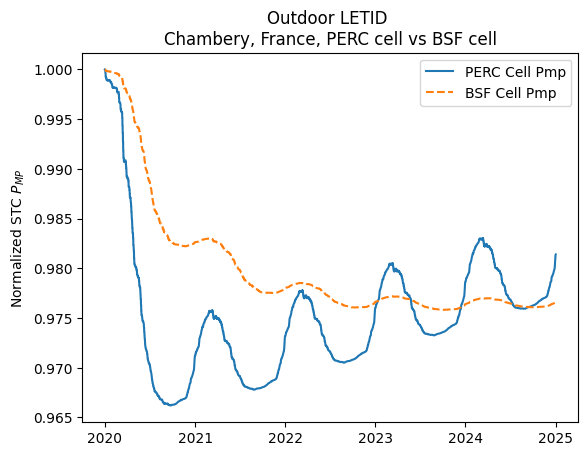

In [151]:
from cycler import cycler
plt.style.use('default')

fig, ax = plt.subplots()

ax.set_prop_cycle(cycler('color', ['tab:blue', 'tab:orange', 'tab:green']) + cycler('linestyle', ['-', '--', '-.']))


ax.plot(timesteps_perc['Datetime'], timesteps_perc['Pmp_norm'], label = 'PERC Cell Pmp')
ax.plot(timesteps_bsf['Datetime'], timesteps_bsf['Pmp_norm'], label = 'BSF Cell Pmp')

ax.legend(loc = 'upper right')
ax.set_ylabel('Normalized STC $P_{MP}$')

ax.set_title('Outdoor LETID \n'f'{location.name}, PERC cell vs BSF cell')

plt.show()